In [1]:
%load_ext autoreload
%autoreload 2

import time
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange
import gym
from ge_world.h_maze import HMazeEnv
from ml_logger import logger
from ml_logger.nb import show

ge.envs environments are now added!


# Overview: A Simple Peg Insertion Domain

Having a large configuration space will increase sample complexity and
make the problem unnecessarily more difficult. The most straightforward
way to limit awkward poses is by directly restricting the joint angles
which does not require computing the absolute position of each joint
in the 2D plain. An added benefit is the state can be initialized using
a uniform distribution. Filtering also becomes less necessary.

The joints are limited to the following range:

```
low = [0, -2.5, 0]
high = [1.5, 0, 2.7]
```

The slot is positioned 28 cm to the right. The arena is the same size
as the other maze environments -- 28 x 28 cm.

# ToDos

- [x] add one-sided version
- [x] add success reward/metric [Getting it to work with SAC?]

Two tasks are available: A free-reaching task without the slot on the right,
and a peg-insertion task.

*3-Link Arm: Free*

  0%|          | 0/40 [00:00<?, ?it/s]

Creating offscreen glfw
Creating offscreen glfw
Creating offscreen glfw


 18%|█▊        | 7/40 [00:00<00:01, 22.90it/s]

Creating offscreen glfw


100%|██████████| 40/40 [00:01<00:00, 38.45it/s]



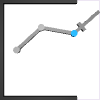
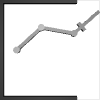
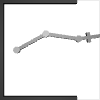
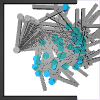

In [2]:
env = gym.make("ge_world:Peg2D-v0", free=True)
env.seed(100)
obs = env.reset()
# with env.with_color(-1):
rgb_img = env.render('rgb', width=100, height=100)

env = gym.make("ge_world:Peg2D-v0", free=True, in_slot=0)
env.seed(100)

imgs = []
for i in trange(40):
    env.reset()
    imgs.append(env.render('rgb', width=100, height=100))

show(rgb_img, obs['img'][0], obs['goal_img'][0], np.stack(imgs, axis=-1).min(axis=-1), titles=["Render", "Img", "Goal", "rho_0"])

*Peg Insertion*

  0%|          | 0/40 [00:00<?, ?it/s]

Creating offscreen glfw
Creating offscreen glfw
Creating offscreen glfw
Creating offscreen glfw


100%|██████████| 40/40 [00:01<00:00, 39.58it/s]



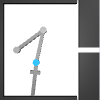
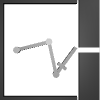
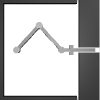
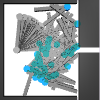

In [3]:
env = gym.make("ge_world:Peg2D-v0", free=False)
env.seed(200)
obs = env.reset_model(slot_y=0)
# info: the object is not the last body anymore.
rgb_img = env.render('rgb', width=100, height=100)

env = gym.make("ge_world:Peg2D-v0", free=False, in_slot=0)
env.seed(100)

imgs = []
for i in trange(40):
    obs = env.reset_model(slot_y=0)
    imgs.append(env.render('rgb', width=100, height=100))

show(rgb_img, obs['img'][0], obs['goal_img'][0], np.stack(imgs, axis=-1).min(axis=-1), titles=["Render", "Img", "Goal", "rho_0"])

Inspect the reward

Creating offscreen glfw



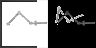
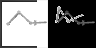
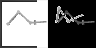
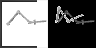
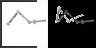
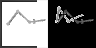
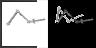
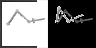
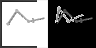
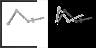
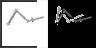
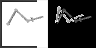
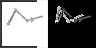
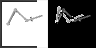
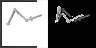
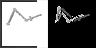
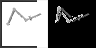
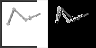
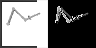
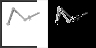
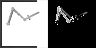
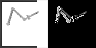
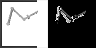
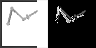
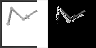
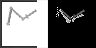
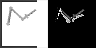
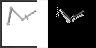
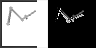
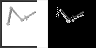
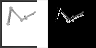
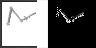
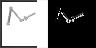
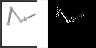
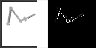
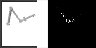

In [4]:
env = gym.make("ge_world:Peg2D-v0", free=True, width=48, height=48)

frames = []

obs, done, i  = env.reset(), False, 0
while not done:
    i += 1
    act =  np.sign(obs['goal'] - obs['x'])
    obs, reward, done, info = env.step(act * 0.5)
    # print(f"\r {reward}", info, obs['x'], obs['goal'], end='')
    frames.append(np.concatenate([obs['img'], obs['goal_img'] - obs['img']], axis=-1)[0])

show(*frames)

Now test the peg insertion reward (and terminal condition).

Note that the `env.reset_model` takes in an integer goal position.

Creating offscreen glfw



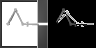
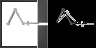
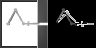
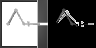
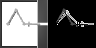
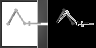
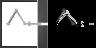
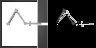
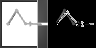
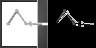
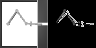
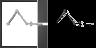
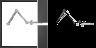
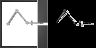
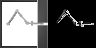
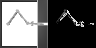
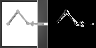
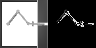
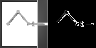
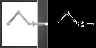
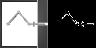
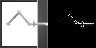

In [5]:
# use the non-free option
env = gym.make("ge_world:Peg2D-v0", width=48, height=48)

frames = []

obs, done, i  = env.reset_model(x=[1.1, -2.2, 1.1], slot_y=0), False, 0
while not done and not logger.every(100):
    i += 1
    act =  np.sign(obs['goal'] - obs['x'])
    obs, reward, done, info = env.step(act * 0.5)
    # print(f"\r {reward}", info, obs['x'], obs['goal'], end='')
    frames.append(np.concatenate([obs['img'], obs['goal_img'] - obs['img']], axis=-1)[0])

show(*frames)


## Mixed-Mode

Now test the "Mixed mode". In this mode, the slot would flash on and off
during rendering, unless the peg is less than 1 cm away from the wall.

This way, the local metric would learn to ignore the slot before it
is relevant.

Specification:

- show slot w/ 50% chance unless end-effector is to the right of 2.7(5)
 cm.

> Note: do *NOT* set the `slot_y` in `env.reset_model` under the free mode.
> The mix_mode includes goal positions. Setting goals through that
> function call would only override the logic that moves the slot
> out-of-the-way.

Creating offscreen glfw



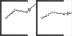
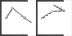
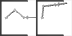
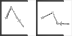
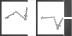
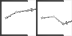
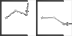
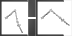
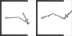
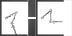

In [6]:
env = gym.make("ge_world:Peg2D-v0", free=True, mix_mode=(1, 0),
               width=36, height=36)
env.seed(100)

frames = []

for i in range(10):
    obs = env.reset_model()
    frames.append(np.concatenate([obs['img'], obs['goal_img']], axis=-1)[0])

show(*frames)

Creating offscreen glfw



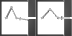
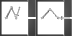
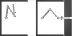
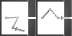
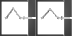
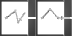
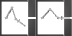
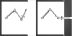
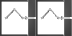
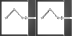

In [7]:
env = gym.make("ge_world:Peg2D-v0", free=False, mix_mode=(1, 0),
               width=36, height=36)
env.seed(100)

frames = []

for i in range(10):
    obs = env.reset_model(slot_y=0)
    frames.append(np.concatenate([obs['img'], obs['goal_img']], axis=-1)[0])

show(*frames)